# Project 2 - Starter Notebook

Please make sure your solution is divided into multiple code cells, explained clearly and properly, and most importantly, pretty.


In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import os,time
from pyspark.sql import SparkSession
 
spark = SparkSession.builder.appName("my_project_2").getOrCreate()

## Read Sub Demographic data

In [0]:
demographic_df = spark.read.parquet("dbfs:/FileStore/project_b_data/proj_B_demographic/")
demographic_df.printSchema()
display(demographic_df.limit(10))

root
 |-- household_id: long (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- num_adults: integer (nullable = true)
 |-- num_generations: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race_code: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- home_owner_status: string (nullable = true)
 |-- length_residence: integer (nullable = true)
 |-- home_market_value: double (nullable = true)
 |-- net_worth: double (nullable = true)
 |-- gender_individual: string (nullable = true)
 |-- education_highest: string (nullable = true)



household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,gender_individual,education_highest
85,2,1,2,B,W,S,O,15,0.125,0.05,F,1
2073,1,1,2,M,H,S,O,15,0.15,0.1,F,1
2523,7,6,3,M,W,S,O,15,0.1,0.1,M,2
2717,3,2,2,S,W,S,O,11,0.125,0.2,M,3
3364,2,2,2,M,W,S,O,15,0.1,0.1,M,1
4046,4,3,3,M,W,S,O,6,0.075,0.05,F,1
4303,1,1,1,S,W,S,O,15,0.15,0.2,M,1
4559,3,2,2,S,W,S,O,12,0.175,0.2,F,2
5277,3,2,2,M,W,S,R,15,0.125,0.02,M,2
5440,1,1,1,S,W,S,O,8,0.225,0.2,F,1


## Read Static Viewing Data

In [0]:
schema = StructType([
    StructField("device_id", StringType(), True),
    StructField("event_date", StringType(), True),
    StructField("event_time", StringType(), True),     
    StructField("station_num", IntegerType(), True),
    StructField("prog_code", StringType(), True),
    StructField("household_id", IntegerType(), True)
])

viewing_static_df = spark.read.schema(schema).option("header", True).csv("dbfs:/FileStore/project_b_data/viewing_static_csv/")

viewing_static_df.printSchema()
display(viewing_static_df.limit(10))

root
 |-- device_id: string (nullable = true)
 |-- event_date: string (nullable = true)
 |-- event_time: string (nullable = true)
 |-- station_num: integer (nullable = true)
 |-- prog_code: string (nullable = true)
 |-- household_id: integer (nullable = true)



device_id,event_date,event_time,station_num,prog_code,household_id
001bd74cc8d1,20150120,181338,75523,EP000009110053,3783713
10ea5940d694,20150120,181338,11218,MV001054110000,3787015
44e08ed80c35,20150120,181338,11713,SH004464010000,43921
0000048de4f2,20150120,181338,65626,MV000506130000,3672067
0000059867a7,20150120,181338,58812,EP019199930005,3645541
000011ff9ba9,20150120,181338,18510,EP010855880111,3642303
00000254e5f6,20150120,181338,35513,EP000369550087,3825751
000002bd8a47,20150120,181338,10035,EP013413450102,2971023
000003c4c597,20150120,181338,59337,MV000744670000,2358722
00407bba00fe,20150120,181338,14771,EP015899250028,2838674


## Static Data Analysis (65 points)

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql import Window, DataFrame
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT

In [0]:
viewing_static_df.cache()
viewing_static_df.count()

demographic_df.cache()
demographic_df.count()

357721

### Feature Extraction

In [0]:
# 1. Numerical columns and categorical columns
numerical_cols = ["household_size", "num_adults", "num_generations", "length_residence", "home_market_value", "net_worth"]
categorical_cols = ["marital_status", "race_code", "dwelling_type", "home_owner_status", "gender_individual", "education_highest"]

# 2. Min-max scale numerical columns manually
summary = demographic_df.select(
    [min(c).alias(c + "_min") for c in numerical_cols] + [max(c).alias(c + "_max") for c in numerical_cols]
).collect()[0]

df_scaled = demographic_df
scaled_cols = []

for c in numerical_cols:
    min_val = summary[c + "_min"]
    max_val = summary[c + "_max"]
    scaled_col = f"{c}_scaled"
    if max_val != min_val:
        df_scaled = df_scaled.withColumn(scaled_col, (col(c) - min_val) / (max_val - min_val))
    else:
        df_scaled = df_scaled.withColumn(scaled_col, col(c) * 0)
    scaled_cols.append(scaled_col)

# 3. Index categorical columns
indexed_cols = []
for c in categorical_cols:
    indexer = StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid="skip")
    df_scaled = indexer.fit(df_scaled).transform(df_scaled)
    indexed_cols.append(c + "_index")

# 4. OneHotEncode indexed columns
encoder = OneHotEncoder(inputCols=indexed_cols, outputCols=[c + "_ohe" for c in categorical_cols])
df_scaled = encoder.fit(df_scaled).transform(df_scaled)

# 5. Assemble features vector
feature_cols = scaled_cols + [c + "_ohe" for c in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
processed_df = assembler.transform(df_scaled).cache()

# 6. Show results
processed_df.select("household_id", "features").show(7, truncate=False)

🏃 View run rare-dog-609 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/2120248986648755/runs/ba3b1a25dbae4b4a859506dbd04c86bb
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/2120248986648755
🏃 View run bright-fish-444 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/2120248986648755/runs/85d4c765dc0c43ba9cf43f1a32ea8fca
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/2120248986648755
🏃 View run fearless-pig-604 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/2120248986648755/runs/8e3698a13ddd450e8123fc0a2d360049
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/2120248986648755
🏃 View run selective-squid-374 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/2120248986648755/runs/baa3b84be280447d97367cc3c8f0ed78
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experim

### Visual Analysis

🏃 View run victorious-vole-999 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/2120248986648755/runs/ed9028c4cae14d34abd88b917d475fd0
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/2120248986648755
+------------+-----------+------------+
|household_id|pca_1      |pca_2       |
+------------+-----------+------------+
|85          |0.7696162  |-0.1432845  |
|2073        |1.0470607  |-0.8077002  |
|2523        |-0.21564461|-1.649638   |
|2717        |-0.14727134|-0.009878108|
|3364        |1.0866265  |-1.0202633  |
|4046        |0.9640643  |-0.95014834 |
|4303        |0.68522584 |0.33186218  |
+------------+-----------+------------+
only showing top 7 rows



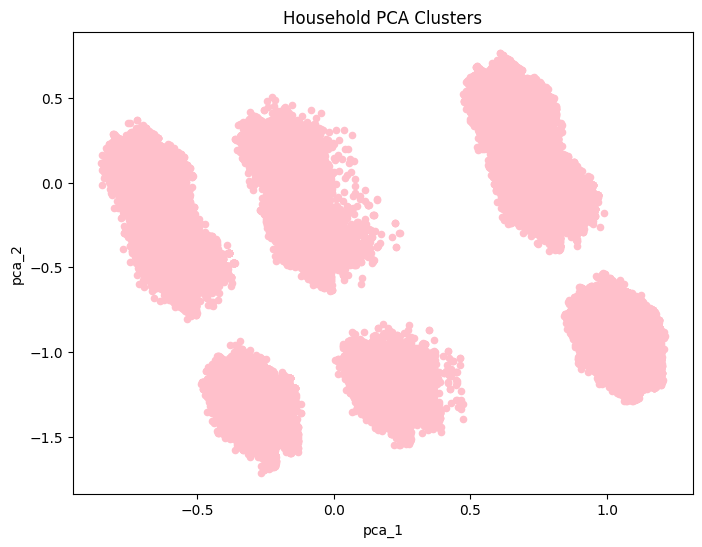

In [0]:
# Step 1: Initialize PCA with k=2
pca = PCA(k=2, inputCol="features", outputCol="pca_features")

# Step 2: Fit PCA model and transform data
pca_model = pca.fit(processed_df)
pca_df = pca_model.transform(processed_df)

# Step 3: Extract the two PCA components into separate columns for plotting
def extract_pca_components(v):
    return float(v[0]), float(v[1])

extract_udf = udf(extract_pca_components, StructType([
    StructField("pca_1", FloatType(), False),
    StructField("pca_2", FloatType(), False)
]))

pca_df = pca_df.withColumn("pca_struct", extract_udf("pca_features"))
pca_df = pca_df.select(
    "household_id",
    "pca_struct.pca_1",
    "pca_struct.pca_2"
)

# Show 7 rows
pca_df.show(7, truncate=False)

# Step 4: Convert to pandas for plotting
pandas_df = pca_df.toPandas()

# Step 5: Plot scatter plot with pink points
pandas_df.plot.scatter(x='pca_1', y='pca_2', color='pink', figsize=(8,6), title='Household PCA Clusters')
plt.show()

### Clustering

In [0]:
# Set number of clusters and initialize KMeans
k = 6
kmeans = KMeans(k=k, seed=3, featuresCol="features", predictionCol="cluster")

# Fit the model and transform data to assign clusters
model = kmeans.fit(processed_df)
clustered_df = model.transform(processed_df)

# Retrieve cluster centers
centers = model.clusterCenters()

# Define UDF to compute distance to cluster centroid
def compute_distance(features, cluster_idx):
    center = centers[cluster_idx]
    f_array = features.toArray()
    
    # Manual sum of squared differences
    total = 0.0
    for a, b in zip(f_array, center):
        total += (a - b) ** 2
    
    return float(total ** 0.5)

distance_udf = udf(compute_distance, FloatType())

# Add distance column
clustered_df = clustered_df.withColumn("distance_to_centroid", distance_udf("features", "cluster"))

# Show 7 rows with household_id, cluster, and distance
clustered_df.select("household_id", "cluster", "distance_to_centroid").show(7, truncate=False)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run adorable-mare-788 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/2120248986648755/runs/13c7027140824e3b8b2005f097dbe607
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/2120248986648755
+------------+-------+--------------------+
|household_id|cluster|distance_to_centroid|
+------------+-------+--------------------+
|85          |1      |0.95686495          |
|2073        |2      |0.8481486           |
|2523        |0      |1.329641            |
|2717        |1      |1.4315091           |
|3364        |5      |0.5861586           |
|4046        |5      |0.9358106           |
|4303        |1      |0.9705721           |
+------------+-------+--------------------+
only showing top 7 rows



### Dividing households into subsets

In [0]:
# Define window partitioned by cluster, ordered by ascending distance to centroid
w = Window.partitionBy("cluster").orderBy("distance_to_centroid")

# Add a row number within each cluster
clustered_df = clustered_df.withColumn("row_num", row_number().over(w))

# Define subsets with conditions on row_num
clustered_df = clustered_df.withColumn(
    "subset_full", lit(True)  # full subset contains all rows
).withColumn(
    "subset_3rds", when((col("row_num") % 3) == 0, True).otherwise(False)
).withColumn(
    "subset_17ths", when((col("row_num") % 17) == 0, True).otherwise(False)
)

# Show example rows with subset flags
clustered_df.select(
    "household_id", "cluster", "row_num", "subset_full", "subset_3rds", "subset_17ths"
).show(7, truncate=False)


+------------+-------+-------+-----------+-----------+------------+
|household_id|cluster|row_num|subset_full|subset_3rds|subset_17ths|
+------------+-------+-------+-----------+-----------+------------+
|2870796     |1      |1      |true       |false      |false       |
|3631022     |1      |2      |true       |false      |false       |
|3799062     |1      |3      |true       |true       |false       |
|2357515     |1      |4      |true       |false      |false       |
|107954      |1      |5      |true       |false      |false       |
|4687821     |1      |6      |true       |true       |false       |
|4015214     |1      |7      |true       |false      |false       |
+------------+-------+-------+-----------+-----------+------------+
only showing top 7 rows



### Cluster’s Viewing Analysis

In [0]:
# Join viewing data with cluster and subset info
viewing_with_clusters = viewing_static_df.join(
    clustered_df.select("household_id", "cluster", "subset_full", "subset_3rds", "subset_17ths"),
    on="household_id",
    how="inner"
)

# Calculate general population station counts and percentages
total_viewings = viewing_with_clusters.count()

general_station_counts = viewing_with_clusters.groupBy("station_num").agg(count("*").alias("count"))
general_station_pct = general_station_counts.withColumn(
    "general_pct", (col("count") / total_viewings) * 100
).select("station_num", "general_pct")

# Define subsets to process
subsets = [("Full", "subset_full"), ("3rds", "subset_3rds"), ("17ths", "subset_17ths")]
clusters = [row['cluster'] for row in clustered_df.select("cluster").distinct().collect()]

# Initialize combined_results and row count tracker
combined_results = None
num_result_blocks = 0

for cluster_id in clusters:
    for subset_name, subset_col in subsets:
        subset_viewings = viewing_with_clusters.filter(
            (col("cluster") == cluster_id) & (col(subset_col) == True)
        )

        subset_total = subset_viewings.count()
        if subset_total == 0:
            continue

        subset_counts = subset_viewings.groupBy("station_num").agg(count("*").alias("subset_count"))

        subset_pct = subset_counts.withColumn(
            "subset_pct", (col("subset_count") / subset_total) * 100
        ).select("station_num", "subset_pct")

        joined = subset_pct.join(general_station_pct, "station_num", "left_outer").fillna(0)

        diff_rank_df = joined.withColumn("diff_rank", col("subset_pct") - col("general_pct"))

        top_stations = diff_rank_df.orderBy(desc("diff_rank")).limit(7)
        top_stations = top_stations.withColumn("cluster", lit(cluster_id)).withColumn("subset", lit(subset_name))

        if combined_results is None:
            combined_results = top_stations
        else:
            combined_results = combined_results.unionByName(top_stations)

        num_result_blocks += 1

# Show all top stations (7 per subset/cluster combo)
final_df = combined_results.select("cluster", "subset", "station_num", "diff_rank")

In [0]:
from IPython.display import display, HTML
import pandas as pd

# Convert Spark DataFrame to Pandas for easier HTML formatting
pandas_df = final_df.toPandas()

# Sort to maintain consistent ordering
pandas_df = pandas_df.sort_values(by=['cluster', 'subset', 'diff_rank'], ascending=[True, True, False])

# Group by cluster
clusters = pandas_df['cluster'].unique()

html_output = ""

for cluster in clusters:
    html_output += f"<h2>Cluster {cluster}</h2><div style='display: flex; gap: 40px;'>"
    
    for subset in ['Full', '3rds', '17ths']:
        subset_df = pandas_df[(pandas_df['cluster'] == cluster) & (pandas_df['subset'] == subset)][['station_num', 'diff_rank']]
        html_output += f"""
        <div>
            <h3>{subset}</h3>
            {subset_df.to_html(index=False, border=1, justify='left')}
        </div>
        """
    
    html_output += "</div><hr>"

# Display the final HTML
display(HTML(html_output))

station_num,diff_rank
60179,0.392001
16374,0.227303
49788,0.204553
32645,0.100178
10335,0.087455
50747,0.080610
61854,0.075668
station_num,diff_rank
60179,0.278368
32645,0.247454


## Dynamic Data Analysis - Streaming (35 points)

In [0]:
from pyspark.sql import DataFrame
from pyspark.sql.streaming import DataStreamWriter
import time

In [0]:
SCHEMA = "device_id STRING, event_date INT, event_time INT, station_num STRING, prog_code STRING, household_id STRING"
kafka_server = "kafka.eastus.cloudapp.azure.com:29092"
topic = "view_data" 
OFFSETS_PER_TRIGGER = 50000

streaming_df = spark.readStream\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER)\
                  .load()\
                  .select(from_csv(decode("value", "US-ASCII"), schema=SCHEMA).alias("value")).select("value.*")

In [0]:
import pyspark.sql.functions as F

# Global counters and accumulators
batch_count = 0
MIN_BATCHES_TO_PROCESS = 3
max_rows = 50

# Cumulative state dictionaries
cumulative_subset_counts = {}
cumulative_general_counts = {}

def process_batch(df, epoch_id):
    global batch_count, cumulative_subset_counts, cumulative_general_counts

    batch_count += 1

    if df.isEmpty():
        print(f"Batch {batch_count} is empty. Skipping analysis.")
        if batch_count >= MIN_BATCHES_TO_PROCESS:
            try:
                print(f"Processed at least {MIN_BATCHES_TO_PROCESS} batches. Stopping stream.")
                query.stop()
            except Exception as e:
                print(f"Caught exception while stopping (expected during shutdown): {e}")
        return

    # Join with clustering info
    batch_with_cluster_info = df.join(
        broadcast(clustered_df.select("household_id", "cluster", "subset_3rds")),
        on="household_id",
        how="inner"
    )

    # Subset: only "3rds"
    subset_df = batch_with_cluster_info.filter(col("subset_3rds") == True)

    # Subset counts per cluster/station
    subset_counts = subset_df.groupBy("cluster", "station_num").agg(F.count("*").alias("subset_count"))

    # General counts per cluster/station
    general_counts = batch_with_cluster_info.groupBy("cluster", "station_num").agg(F.count("*").alias("general_count"))

    # Update cumulative counts (subset)
    for row in subset_counts.collect():
        key = (row['cluster'], row['station_num'])
        cumulative_subset_counts[key] = cumulative_subset_counts.get(key, 0) + row['subset_count']

    # Update cumulative counts (general)
    for row in general_counts.collect():
        key = (row['cluster'], row['station_num'])
        cumulative_general_counts[key] = cumulative_general_counts.get(key, 0) + row['general_count']

    # Compute cumulative totals per cluster
    cumulative_subset_totals = {}
    cumulative_general_totals = {}

    for (cluster, _), count in cumulative_subset_counts.items():
        cumulative_subset_totals[cluster] = cumulative_subset_totals.get(cluster, 0) + count

    for (cluster, _), count in cumulative_general_counts.items():
        cumulative_general_totals[cluster] = cumulative_general_totals.get(cluster, 0) + count

    # Build cumulative diff_rank list
    rows = []
    for (cluster, station) in cumulative_subset_counts:
        subset_count = cumulative_subset_counts[(cluster, station)]
        general_count = cumulative_general_counts.get((cluster, station), 0)

        subset_total = cumulative_subset_totals[cluster]
        general_total = cumulative_general_totals.get(cluster, 0)

        subset_pct = (subset_count / subset_total) * 100 if subset_total else 0
        general_pct = (general_count / general_total) * 100 if general_total else 0

        diff = subset_pct - general_pct
        rows.append((cluster, station, diff))

    # Convert to DataFrame
    diff_rank_df = spark.createDataFrame(rows, ["cluster", "station_num", "diff_rank"])

    # Top 7 stations per cluster by cumulative diff_rank
    window_spec = Window.partitionBy("cluster").orderBy(col("diff_rank").desc())
    top_diff_rank = diff_rank_df.withColumn("rank", rank().over(window_spec)) \
        .filter(col("rank") <= 7) \
        .select("cluster", "station_num", "diff_rank") \
        .orderBy("cluster", col("diff_rank").desc())

    print(f"Top Stations per Cluster by cumulative diff_rank (3rds subset) - Batch {batch_count}:")
    top_diff_rank.show(n=max_rows, truncate=False)

    if batch_count >= MIN_BATCHES_TO_PROCESS:
        try:
            query.stop()
        except Exception as e:
            pass


# Start the streaming query
query = streaming_df.writeStream \
    .outputMode("append") \
    .foreachBatch(process_batch) \
    .start()

print("Streaming query started. Waiting for batches...")

query.awaitTermination()
print("Streaming process complete.")

Streaming query started. Waiting for batches...
Top Stations per Cluster by cumulative diff_rank (3rds subset) - Batch 1:
+-------+-----------+-------------------+
|cluster|station_num|diff_rank          |
+-------+-----------+-------------------+
|0      |32645      |0.6545567491111535 |
|0      |11150      |0.3663890507698895 |
|0      |10142      |0.3397109784317117 |
|0      |11164      |0.3289651967812214 |
|0      |11158      |0.3103270179764027 |
|0      |10057      |0.3024346208220746 |
|0      |10021      |0.25522773427513623|
|1      |14771      |0.4296431285528839 |
|1      |12131      |0.32321660378825023|
|1      |10145      |0.30635116359920533|
|1      |11713      |0.28078792970966093|
|1      |70522      |0.24087692685278   |
|1      |16300      |0.23690187883327057|
|1      |25544      |0.2118497828930999 |
|2      |10647      |0.7296580251695254 |
|2      |12574      |0.6615144294277733 |
|2      |10731      |0.628596883178621  |
|2      |18480      |0.496926698182010